# Contents

In this Notebook I will Learn the RNN and its varient.
* Simple RNN's
* Word Embeddings : Definition and How to get them
* LSTM's
* GRU's
* BI-Directional RNN's
* Encoder-Decoder Models (Seq2Seq Models)
* Attention Models
* Transformers - Attention is all you need
* BERT
# Basic Help When Needed
- To Represent the world cloud and LDA use the below link
* https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial

## Basic Information Regarding Sequence Model
- models that regress the value of a signal on the previous values of that same signal are naturally called autoregressive models
- First of all, we might believe that although long sequences $\boldsymbol{x}_{t-1},\ldots,\boldsymbol{x}_1$ are available, it may not be necessary to look back so far in the history when predicting the near future. In this case we might content ourselves to condition on some window of length $\tau$ and only use $\boldsymbol{x}_{t-1},\ldots,\boldsymbol{x}_{t-\tau}$ observations. The immediate benefit is that now the number of arguments is always the same, at least for $t > \tau$. This allows us to train any linear model or deep network that requires fixed-length vectors as inputs.

- Second, we might develop models that maintain some summary $\boldsymbol{h}_t$ of the past observations (see Fig. 9.1.2) and at the same time update $\boldsymbol{h}_t$ in addition to the prediction $\hat{\boldsymbol{x}}^t$. This leads to models that estimate not only $\boldsymbol{x}_t$ with $\hat{\boldsymbol{x}}_t = P(\boldsymbol{x}_t|\boldsymbol{h}_t)$ but also updates of the form $\boldsymbol{h}_t = g(\boldsymbol{h}_{t-1}, \boldsymbol{x}_{t-1})$. Since $\boldsymbol{h}_t$ is never observed, these models are also called latent autoregressive models.
## Language Model
- when working with language, we wish to estimate the joint probability of an entire sequence. This is a common task when working with sequences composed of discrete tokens, such as words. Generally, these estimated functions are called sequence models and for natural language data, they are called language models.
- Language modeling as autoregression: P(x_1, ..., x_T) decomposed using chain rule into P(x_1) * P(x_2 | x_1) * ... * P(x_T | x_(T-1), ..., x_1). Autoregressive prediction: predict x_t based on x_(t-1), ..., x_1.
- Now suppose that we wish to employ the strategy mentioned above, where we condition only on the "a" previous time steps rather then entire sequence history "t" when we does this it satifies a Markov condition, i.e., that the future is conditionally independent of the past, given the recent history. when a=1 then 1st order Markov model. 
- We often find it useful to work with models that proceed as though a Markov condition were satisfied, even when we know that this is only approximately true. 
- Sometimes we compromise, obviating computational and statistical difficulties by training models whose validity depends on a Kth -order Markov condition. Even today’s massive RNN- and Transformer-based language models seldom incorporate more than thousands of words of context.
-  why we represented the factorization of a text sequence  as a left-to-right chain of conditional probabilities. ans(represent sequence as we read as it better for other lang like arabic that right to left)


In [1]:
# libraries
import collections # libraries for different DS
import random # to generate random numbers
import re # regular expression using in preprocessing
import torch # pytorch library
import pandas as pd # pandas to read and manipulate the 
import nltk # text processing library
from nltk.corpus import stopwords # stop words library
from sklearn.feature_extraction.text import CountVectorizer # used for finding vaccub
import gensim # pretrained model by google for converting word to vector
from gensim.models import Word2Vec # word 2 vector 
import numpy as np # processing effeciently vectors
from gensim.test.utils import datapath # load the datapath 
import torch.nn as nn # neural network  base class
from torch.utils.data import DataLoader, Dataset # construct dataset to store in the 
from sklearn.model_selection import train_test_split # Define dataset and dataloader for efficient
import torch.optim as optim ## for smapling different paramter to findd the optimal parameter for any neural network
import math # math operations
from torch.nn import functional as F # (forwords functions)

## Converting Raw Text into Sequence Data

In [3]:
text='the time machine by h g wells i the time traveller for so it'
tokens=list(text)
class Vocab:  #@save
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [16, 8, 5, 0, 16, 9, 11, 5, 0, 11]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


In [4]:
print("unigram model")
words = text.split()
vocab = Vocab(words)
print(vocab.token_freqs[:10])
print("Bigram model")
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
print(bigram_vocab.token_freqs[:10])

unigram model
[('the', 2), ('time', 2), ('machine', 1), ('by', 1), ('h', 1), ('g', 1), ('wells', 1), ('i', 1), ('traveller', 1), ('for', 1)]
Bigram model
[('the--time', 2), ('time--machine', 1), ('machine--by', 1), ('by--h', 1), ('h--g', 1), ('g--wells', 1), ('wells--i', 1), ('i--the', 1), ('time--traveller', 1), ('traveller--for', 1)]


## RNN
What is a RNN?

Recurrent Neural Network(RNN) are a type of Neural Network where the output from previous step are fed as input to the current step. In traditional neural networks, all the inputs and outputs are independent of each other, but in cases like when it is required to predict the next word of a sentence, the previous words are required and hence there is a need to remember the previous words. Thus RNN came into existence, which solved this issue with the help of a Hidden Layer.

Why RNN's?
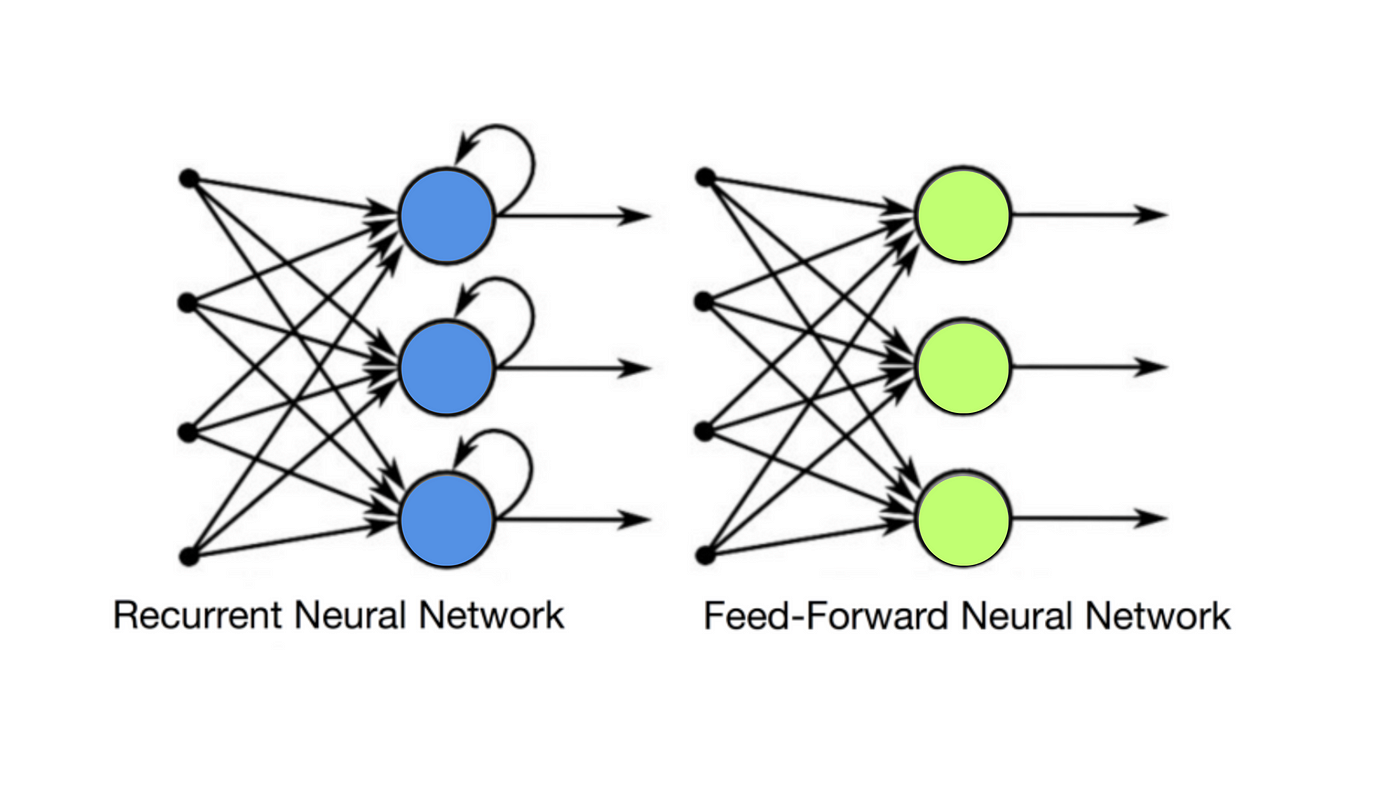


### MLP with single layer
when we look to MLP with a single hidden layer. Let the hidden layer's activation function be $\phi$. Given a minibatch of examples $\mathbf{X} \in \mathbb{R}^{n \times d}$ with batch size $n$ and $d$ inputs, the hidden layer output $\mathbf{H} \in \mathbb{R}^{n \times h}$ is calculated as
\begin{equation}
\mathbf{H} = \phi(\mathbf{X}\mathbf{W}_{xh} + \mathbf{b}_h).
\end{equation}
Here , we have the weight parameter $\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$, the bias parameter $\mathbf{b}_h \in \mathbb{R}^{1 \times h}$, and the number of hidden units $h$ for the hidden layer. So armed, we apply broadcasting (passing input to all the nodes) during the summation. Next, the hidden layer output $\mathbf{H}$ is used as input of the output layer, which is given by
\begin{equation}
\mathbf{O} = \mathbf{H}\mathbf{W}_{hq} + \mathbf{b}_q,
\end{equation}
where $\mathbf{O} \in \mathbb{R}^{n \times q}$ is the output variable, $\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$ is the weight parameter, and $\mathbf{b}_q \in \mathbb{R}^{1 \times q}$ is the bias parameter of the output layer. If it is a classification problem, we can use softmax to compute the probability distribution of the output categories.

This is entirely analogous to the regression problem so we can pick feature-label pairs at random and learn the parameters of our network via automatic differentiation and stochastic gradient descent.

However, this feedforward networks struggle with sequential data like text or time series, where the order and relationships between elements are important

### Recurrent Neural Networks with Hidden States
RNNs address this limitation by incorporating a concept called memory. This allows them to consider not only the current input but also the context of previous inputs.

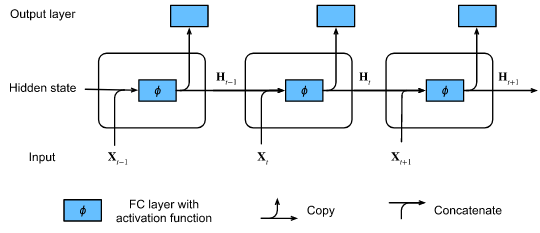

\begin{align*}
h_t &= f(W_{hh} \cdot h_{t-1} + W_x \cdot x_t + b) \\
o_t &= g(W_o \cdot h_t + b_o)
\end{align*}

Where ,
- h_t: Hidden state vector at time step t.
- f: Activation function (e.g., sigmoid, tanh).
- W_{hh}: Weight matrix connecting the hidden layer to itself.
- h_{t-1}: Hidden state vector at the previous time step (t-1).
- W_x: Weight matrix connecting the input layer to the hidden layer.
- x_t: Input vector at time step t.
- b: Bias vector for the hidden layer.
- o_t: Output vector at time step t.
- g: Activation function for the output layer (e.g., sigmoid, softmax).
- W_o: Weight matrix connecting the hidden layer to the output layer.
- b_o: Bias vector for the output layer.

- Recurrent Connection:

    - The key aspect of RNNs is the recurrent connection. The hidden state (h_t) is not just fed forward to the output layer; it's also fed back as input to the network at the next time step. This allows the network to carry information across time steps, making it suitable for processing sequential data.
    
- In Most of the RNN implimentation uses the concept called Tokenization
    -  It takes all the unique words in the corpus,forms a dictionary with words as keys and their number of occurences as values,it then sorts the dictionary in descending order of counts. It then assigns the first value 1 , second value 2 and so on. So let's suppose word 'the' occured the most in the corpus then it will assigned index 1 and vector representing 'the' would be a one-hot vector with value 1 at position 1 and rest zereos.
- A character-level language model based on the RNN
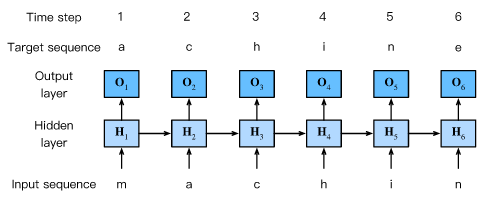

### LSTM
- Simple RNN's were certainly better than classical ML algorithms and gave state of the art results, but it failed to capture long term dependencies that is present in sentences . So in 1998-99 LSTM's were introduced to counter to these drawbacks.

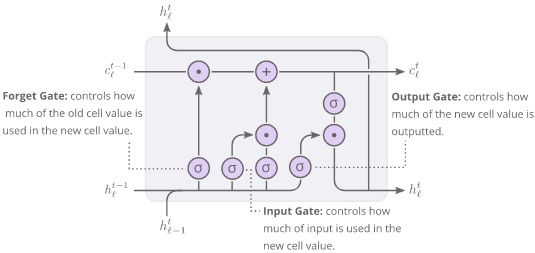

### GRU
Introduced by Cho, et al. in 2014, GRU (Gated Recurrent Unit) aims to solve the vanishing gradient problem which comes with a standard recurrent neural network. GRU's are a variation on the LSTM because both are designed similarly and, in some cases, produce equally excellent results . GRU's were designed to be simpler and faster than LSTM's and in most cases produce equally good results and thus there is no clear winner.
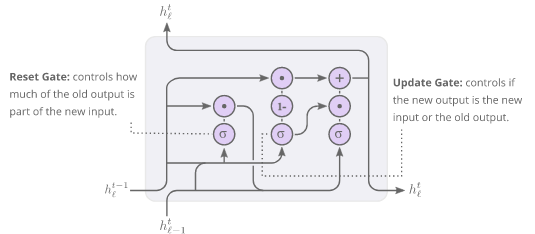


### BOTH 
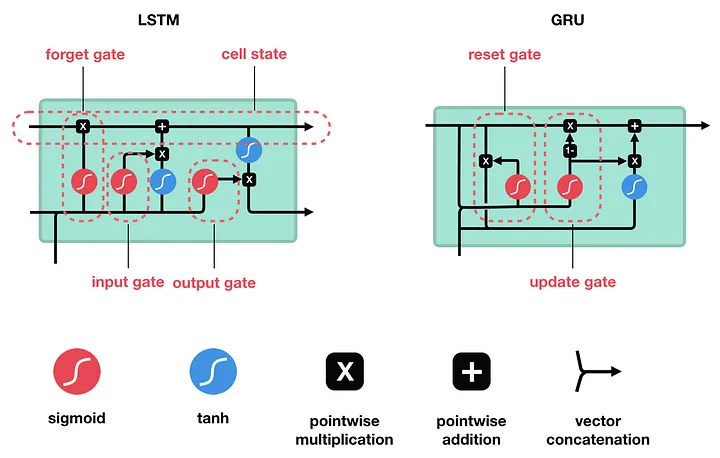


### BI-DIRECTIONAL RNN

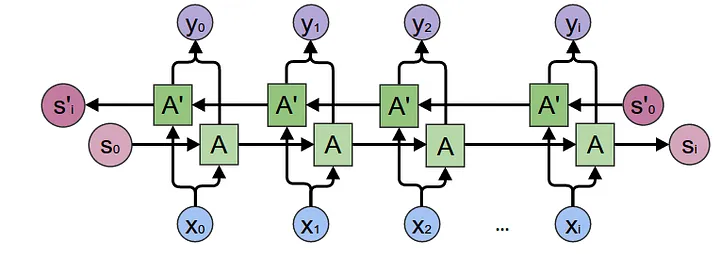
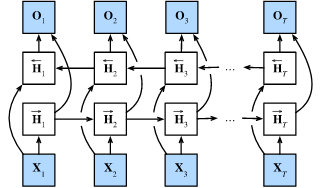

In [6]:
## RNN (basic Structure) Implimentation
class RNNScratch(torch.nn.Module):
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.sigma = sigma
    
        # Initialize weights and biases using torch.nn.Parameter
        self.W_xh = torch.nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = torch.nn.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = torch.nn.Parameter(torch.zeros(num_hiddens))

    def forward(self, inputs, state=None):
        if state is None:
            # Initial state with shape: (batch_size, num_hiddens)
            state = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
        else:
            state, = state  # Unpack the state 

        outputs = []
        for X in inputs:  # Loop through each input vector in the sequence
            state = torch.tanh(torch.matmul(X, self.W_xh) + torch.matmul(state, self.W_hh) + self.b_h)
            outputs.append(state)
        return outputs, state
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

In [7]:
def check_len(a, n):  #@save
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):  #@save
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

## RNN for News Article Classification
- Since this is an classification task we can accumulate all the sequence information using avg output.

In [2]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load the train and test datasets
train_df = pd.read_csv('/kaggle/input/nlp-ass-3/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-ass-3/test.csv')

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\\+', ' ', text)  # Replace '\\\\' with space
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    tokens = text.split()  # Split text into tokens
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    
    text = ' '.join(tokens)  # Remove stopwords
    return text

# Apply preprocessing to train and test data
train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

# Display the preprocessed data
print(train_df['text'].head())
print(test_df['text'].head())
# Display the preprocessed data
# print(train_df['label'].nunique())
# print(test_df['label'].nunique())


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
0    zimbabwe annual inflation drops percent report...
1    dead haiti mass grave haiti holds bodies may m...
2    seven die japan suicide pact japanese police f...
3    security afghan head president hamid karzai pr...
4    palestinians say hope bush accepts dealing ara...
Name: text, dtype: object
0    detainees seen minimal threat washington alleg...
1    japans army works plan cope north korean terro...
2    un council arrives nairobi un security council...
3    apec ministers urge new effort trade talks pac...
4    least five dead russia mine blast reuters reut...
Name: text, dtype: object


In [8]:
print("Sample of preprocessed data:")
print(train_df['text'].sample(10))
train_df['label'].value_counts()
# dataset is balanced

Sample of preprocessed data:
746     packers edge lions ap ap green bay packers led...
295     former rebel leader elected kosovo prime minis...
1298    iata airlines lose b b san francisco cbsmw hig...
1153    jp morgan takes workers ibm outsourcing deal e...
1243    google jumps pc debut new york cnnmoney google...
1827    groups join seek action global warming ap ap d...
447     kerrys unilateralism exchanges first president...
612     shotput returns ancient stadium thens aug amer...
1157    schwab cuts trading fees stock reuters reuters...
483     dead raid closed township baghdad northern ira...
Name: text, dtype: object


label
0    500
1    500
2    500
3    500
Name: count, dtype: int64

In [9]:
# Create a CountVectorizer to create the vocabulary
vectorizer = CountVectorizer(min_df=5, max_df=0.95) 

# Fit the vectorizer on the train data
vectorizer.fit(train_df['text'])

# Vocabulary
vocabulary = vectorizer.get_feature_names_out()

# Display some vocabulary words
print("Vocabulary size:", len(vocabulary))
print("Sample vocabulary:", vocabulary[:200])

# Load pre-trained Word2Vec model
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(datapath('word2vec_pre_kv_c'), binary=False)

# Function to get word embeddings for a sentence
def get_sentence_embedding(sentence, word2vec_model):
    tokens = sentence.split()
    embeddings = [word2vec_model[word] for word in tokens if word in word2vec_model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# Generate embeddings for train and test data
# Generate embeddings for train and test data
train_embeddings = [get_sentence_embedding(sentence, word2vec_model) for sentence in train_df['text']]
test_embeddings = [get_sentence_embedding(sentence, word2vec_model) for sentence in test_df['text']]


Vocabulary size: 1975
Sample vocabulary: ['abbas' 'ability' 'able' 'access' 'according' 'accounting' 'accused'
 'acquisition' 'across' 'act' 'action' 'ad' 'add' 'added' 'adding'
 'administration' 'admitted' 'adopted' 'adrian' 'advance' 'advanced'
 'advantage' 'advertising' 'afghan' 'afghanistan' 'afp' 'africa' 'african'
 'afternoon' 'agency' 'agent' 'ago' 'agree' 'agreed' 'agreement' 'ahead'
 'aid' 'aimed' 'aims' 'air' 'aircraft' 'airline' 'airlines' 'airport' 'al'
 'alex' 'allawi' 'allegations' 'alleged' 'allow' 'allowed' 'allowing'
 'allows' 'almost' 'along' 'already' 'also' 'alternative' 'although'
 'america' 'american' 'americans' 'americas' 'amid' 'among' 'amp'
 'anaheim' 'analysts' 'ancient' 'angeles' 'angels' 'announce' 'announced'
 'announcement' 'announces' 'annual' 'another' 'anticipated' 'antitrust'
 'antonio' 'ap' 'apart' 'appeal' 'appeals' 'appearance' 'appeared'
 'appears' 'apple' 'application' 'applications' 'arab' 'arafat'
 'arbitration' 'area' 'ariel' 'arizona' 'armed'

In [10]:
# Tokenization and Padding/Truncating
max_seq_length = 85

def tokenize_and_pad(text, word2vec_model, max_seq_length):
    """
    Why we do padding? (Note: All the text data has the differnt length)
    max_seq_length (length of each review should not be more then 45 length here)
    padding does: if my sentence have 20 length but max_seqlentgh =45 so it will padd them
    with 25 zeros at end. or there is other we can do as it is implimented in tf that we can
    do prepadding as well.  with these each of ensure it will be of same length.
    We do this padding because (theoritcally it can be of differnt thing) if we have differnt
    length input sequence then we pass each word with each sentence sequentially and perform 
    sgd with batch=1 for every word so it will take very much time so we use batch size of k
    here by converting into the same length we can descrese processing time.
    """
    tokens = text.split()[:max_seq_length]  # Truncate to max_seq_length
    token_ids = [word2vec_model.key_to_index[word] for word in tokens if word in word2vec_model.key_to_index]
    padded_token_ids =  [0] * (max_seq_length - len(token_ids)) + token_ids  # Pad with zeros
    return torch.tensor(padded_token_ids, dtype=torch.long)  # Convert to torch.LongTensor


# Apply the updated function to preprocess the text and generate token IDs
train_df['token_ids'] = train_df['text'].apply(lambda x: tokenize_and_pad(x, word2vec_model, max_seq_length))
test_df['token_ids'] = test_df['text'].apply(lambda x: tokenize_and_pad(x, word2vec_model, max_seq_length))


# Convert token_ids to PyTorch tensors
train_data = [(torch.tensor(token_ids, dtype=torch.long), label) for token_ids, label in zip(train_df['token_ids'], train_df['label'])]
test_data = [(torch.tensor(token_ids, dtype=torch.long), 0) for token_ids in test_df['token_ids']]  # Dummy labels for test data

# Define dataset and dataloader
class TextDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

batch_size = 32
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

train_dataloader = DataLoader(TextDataset(train_data), batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(TextDataset(val_data), batch_size=batch_size)
test_dataloader = DataLoader(TextDataset(test_data), batch_size=batch_size)

/tmp/ipykernel_34/910297543.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = [(torch.tensor(token_ids, dtype=torch.long), label) for token_ids, label in zip(train_df['token_ids'], train_df['label'])]
/tmp/ipykernel_34/910297543.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = [(torch.tensor(token_ids, dtype=torch.long), 0) for token_ids in test_df['token_ids']]  # Dummy labels for test data


In [11]:
# Define the RNN model with Vanilla RNN
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, embedding_weights, bidirectional=True):
        super(VanillaRNN, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=True)
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=bidirectional)    
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_out, _ = self.rnn(embedded)
        # Second RNN layer
#         rnn_out2, _ = self.rnn2(rnn_out)
        avg_out = torch.mean(rnn_out, dim=1)
        out = self.dropout(avg_out)
        out = self.fc(out)
        return out
# Define the RNN model with LSTM (single layer of lstm) (for classification task)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, embedding_weights, bidirectional=True):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=True)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)
        self.dropout = nn.Dropout(0.12)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        avg_out = torch.mean(lstm_out, dim=1)
        out = self.dropout(avg_out)
        out = self.fc(out)
        return out

# Initialize the embedding layer with Word2Vec embeddings
embedding_weights = torch.FloatTensor(word2vec_model.vectors)
input_size = embedding_weights.size(1)  # Size of each embedding vector
output_size = 4  # Binary classification
hidden_size = 128  # Hidden size for RNN/LSTM
print("Embeddings o/p:",input_size,"No of Class:",output_size,"Hidden Size:",hidden_size)
# Instantiate the models
print(embedding_weights[0])
vanilla_rnn_model = VanillaRNN(input_size, hidden_size, output_size, embedding_weights)
lstm_model = LSTMModel(input_size, hidden_size, output_size, embedding_weights)
# Move models to device (CPU/GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vanilla_rnn_model.to(device)
lstm_model.to(device)

# Print model architectures
print("Vanilla RNN Model:\n", vanilla_rnn_model)
print("\nLSTM Model:\n", lstm_model)

Embeddings o/p: 10 No of Class: 4 Hidden Size: 128
tensor([-0.5611, -1.9757,  1.6640, -1.2322,  0.7548,  0.9858,  2.2614, -0.5983,
        -0.4743, -1.4161])
Vanilla RNN Model:
 VanillaRNN(
  (embedding): Embedding(1750, 10)
  (rnn): RNN(10, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

LSTM Model:
 LSTMModel(
  (embedding): Embedding(1750, 10)
  (lstm): LSTM(10, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
  (dropout): Dropout(p=0.12, inplace=False)
)


In [12]:
# For evaluation
from sklearn.metrics import accuracy_score, f1_score
# Training function
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Evaluation function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    return avg_loss, accuracy, f1

In [13]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
# Adjust the learning rate (These Learning Rate found using the optium)
vanilla_rnn_optimizer = optim.Adam(vanilla_rnn_model.parameters(), lr=0.00017)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.0016)
# out(0.2)
# Training and validation
best_val_loss = float('inf')
best_model_state = None
num_epochs = 20

for epoch in range(num_epochs):
    train_loss = train(vanilla_rnn_model, train_dataloader, vanilla_rnn_optimizer, criterion, device)
    val_loss, val_accuracy, val_f1 = evaluate(vanilla_rnn_model, val_dataloader, criterion, device)
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Vanilla RNN - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = vanilla_rnn_model.state_dict()

# Load the best model state
vanilla_rnn_model.load_state_dict(best_model_state)

# Evaluate on test set
test_loss, test_accuracy, test_f1 = evaluate(vanilla_rnn_model, test_dataloader, criterion, device)
print(f'\nVanilla RNN - Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}, Test F1: {test_f1:.4f}')

# Similarly, train and evaluate the LSTM model
best_val_loss = float('inf')
best_model_state = None
for epoch in range(num_epochs):
    train_loss = train(lstm_model, train_dataloader, lstm_optimizer, criterion, device)
    val_loss, val_accuracy, val_f1 = evaluate(lstm_model, val_dataloader, criterion, device)
    
    print(f'Epoch {epoch + 1}/{num_epochs}, LSTM - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = lstm_model.state_dict()

# Load the best model state
lstm_model.load_state_dict(best_model_state)

# Evaluate on test set
test_loss, test_accuracy, test_f1 = evaluate(lstm_model, test_dataloader, criterion, device)
print(f'\nLSTM - Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}, Test F1: {test_f1:.4f}')


Epoch 1/20, Vanilla RNN - Train Loss: 1.3979, Val Loss: 1.3908, Val Acc: 0.2300, Val F1: 0.0935
Epoch 2/20, Vanilla RNN - Train Loss: 1.3902, Val Loss: 1.3862, Val Acc: 0.2650, Val F1: 0.1047
Epoch 3/20, Vanilla RNN - Train Loss: 1.3912, Val Loss: 1.3845, Val Acc: 0.2650, Val F1: 0.1047
Epoch 4/20, Vanilla RNN - Train Loss: 1.3888, Val Loss: 1.3890, Val Acc: 0.2300, Val F1: 0.0935
Epoch 5/20, Vanilla RNN - Train Loss: 1.3878, Val Loss: 1.3859, Val Acc: 0.2300, Val F1: 0.0935
Epoch 6/20, Vanilla RNN - Train Loss: 1.3899, Val Loss: 1.3858, Val Acc: 0.3000, Val F1: 0.1748
Epoch 7/20, Vanilla RNN - Train Loss: 1.3853, Val Loss: 1.3839, Val Acc: 0.2750, Val F1: 0.1078
Epoch 8/20, Vanilla RNN - Train Loss: 1.3908, Val Loss: 1.3878, Val Acc: 0.2300, Val F1: 0.0935
Epoch 9/20, Vanilla RNN - Train Loss: 1.3860, Val Loss: 1.3840, Val Acc: 0.2950, Val F1: 0.1677
Epoch 10/20, Vanilla RNN - Train Loss: 1.3878, Val Loss: 1.3870, Val Acc: 0.2400, Val F1: 0.1665
Epoch 11/20, Vanilla RNN - Train Loss: 

In [14]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
def test_evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return accuracy, f1
# Now, call the corrected test_evaluate function
test_accuracy_vanilla_rnn, test_f1_vanilla_rnn = test_evaluate(vanilla_rnn_model, test_dataloader, device)
test_accuracy_lstm, test_f1_lstm = test_evaluate(lstm_model, test_dataloader, device)

print(f"Vanilla RNN Test Accuracy: {test_accuracy_vanilla_rnn:.4f}, Macro F1 Score: {test_f1_vanilla_rnn:.4f}")
print(f"LSTM Test Accuracy: {test_accuracy_lstm:.4f}, Macro F1 Score: {test_f1_lstm:.4f}")
# Get the true labels and predictions

Vanilla RNN Test Accuracy: 0.9120, Macro F1 Score: 0.3180
LSTM Test Accuracy: 0.3680, Macro F1 Score: 0.1793


## Presenting some example to get prediction out from both the models

In [15]:
# funtion to get the output for given model and text
# here device is the device used to trained the model we can switch as well.
def get_classification(sent_embedd,model=vanilla_rnn_model,device=device):
    model.eval()
    preds=None
    with torch.no_grad():
        # we have make it work in batche so we have unsqeeze to that it will of size [1,max_seq_length]
        # where max_seq_length means maximum allowed sequence
        inputs=sent_embedd.unsqueeze(0).to(device)
        print(inputs.shape)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
    return preds
# printing 10 input from test dataset
# assume we have a text which is enter by user and want to know which 
# (World, Sports, Business, Sci/Tech).
class_labels=["World", "Sports", "Business", "Sci/Tech"]
data =input("Enter the data to find the class of (World, Sports, Business, Sci/Tech).\n")
# process the input text as same as the trainig is done or we can apply based on where data is comming from.
processed_text=preprocess_text(data)
# generate embedding for the processed data but use the same pretrained model to generate 
# the embeddings
input_embedd=tokenize_and_pad(processed_text, word2vec_model, max_seq_length)
print(input_embedd)
new_embedd=input_embedd.clone().detach()
input_embedd=torch.tensor(new_embedd, dtype=torch.long)
# USING VANILA RNN
prediction_RNN=get_classification(input_embedd)
# USING lstm RNN
prediction_LSTM=get_classification(input_embedd,lstm_model)
print("Classificaiton using Vanilla RNN: ",class_labels[prediction_RNN[0]])
print("Classificaiton using LSTM RNN: ",class_labels[prediction_LSTM[0]])

Enter the data to find the class of (World, Sports, Business, Sci/Tech).
 today new technology generated in field of quantum computer.


tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   87,   36, 1048,
         885])
torch.Size([1, 85])
torch.Size([1, 85])
Classificaiton using Vanilla RNN:  Sci/Tech
Classificaiton using LSTM RNN:  Sci/Tech


/tmp/ipykernel_34/1565267714.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_embedd=torch.tensor(new_embedd, dtype=torch.long)


## Bert Implimentation for the above problem


In [3]:
from transformers import RobertaTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
# Load preprocessed data
train_text = train_df['text'].tolist()
train_labels = train_df['label'].tolist()

test_text = test_df['text'].tolist()
test_labels = test_df['label'].tolist()

# Initialize the BERT tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize and pad the sequences
max_length = 512

# Tokenize train sentences
train_encodings = tokenizer(train_text, truncation=True, padding=True, max_length=max_length)
train_input_ids = torch.tensor(train_encodings['input_ids'])
train_attention_masks = torch.tensor(train_encodings['attention_mask'])
train_labels = torch.tensor(train_labels)

# Tokenize test sentences
test_encodings = tokenizer(test_text, truncation=True, padding=True, max_length=max_length)
test_input_ids = torch.tensor(test_encodings['input_ids'])
test_attention_masks = torch.tensor(test_encodings['attention_mask'])
test_labels = torch.tensor(test_labels)

# Splitting the training data into train and validation sets in a 9:1 ratio
train_input_ids, val_input_ids, train_attention_masks, val_attention_masks, train_labels, val_labels = train_test_split(
    train_input_ids, train_attention_masks, train_labels, test_size=0.1, random_state=42
)

# Create TensorDatasets
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# Define batch size
batch_size = 16

# Create Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [5]:
from transformers import RobertaModel, RobertaForSequenceClassification, AdamW
from tqdm import tqdm

# Define BERT model
class BERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BERTClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(self.roberta.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.pooler_output 
        pooled_output = self.drop(pooled_output) 
        logits = self.out(pooled_output)
        return logits

In [6]:
num_classes = train_df['label'].nunique()
# print(num_classes)

# Initialize the model
model = BERTClassifier(num_classes)


# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5)

# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 10
best_val_loss = float('inf')
for epoch in range(num_epochs):
    # Training
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Average training loss for epoch {epoch + 1}: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Average validation loss for epoch {epoch + 1}: {avg_val_loss:.4f}")
    torch.cuda.empty_cache()
    
    # Save the model with best validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saving the best model so far...")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/10: 100%|██████████| 113/113 [00:29<00:00,  3.83it/s]


Average training loss for epoch 1: 0.6435
Average validation loss for epoch 1: 0.4176
Saving the best model so far...


Epoch 2/10: 100%|██████████| 113/113 [00:28<00:00,  3.93it/s]


Average training loss for epoch 2: 0.3329
Average validation loss for epoch 2: 0.3009
Saving the best model so far...


Epoch 3/10: 100%|██████████| 113/113 [00:28<00:00,  3.93it/s]


Average training loss for epoch 3: 0.2340
Average validation loss for epoch 3: 0.3013


Epoch 4/10: 100%|██████████| 113/113 [00:28<00:00,  3.93it/s]


Average training loss for epoch 4: 0.1816
Average validation loss for epoch 4: 0.4480


Epoch 5/10: 100%|██████████| 113/113 [00:28<00:00,  3.93it/s]


Average training loss for epoch 5: 0.1371
Average validation loss for epoch 5: 0.3805


Epoch 6/10: 100%|██████████| 113/113 [00:28<00:00,  3.92it/s]


Average training loss for epoch 6: 0.0967
Average validation loss for epoch 6: 0.4092


Epoch 7/10: 100%|██████████| 113/113 [00:28<00:00,  3.92it/s]


Average training loss for epoch 7: 0.0692
Average validation loss for epoch 7: 0.4290


Epoch 8/10: 100%|██████████| 113/113 [00:28<00:00,  3.92it/s]


Average training loss for epoch 8: 0.0840
Average validation loss for epoch 8: 0.3618


Epoch 9/10: 100%|██████████| 113/113 [00:28<00:00,  3.92it/s]


Average training loss for epoch 9: 0.0577
Average validation loss for epoch 9: 0.4165


Epoch 10/10: 100%|██████████| 113/113 [00:28<00:00,  3.92it/s]


Average training loss for epoch 10: 0.0235
Average validation loss for epoch 10: 0.3991


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Accuracy: 0.8980
Macro-F1 Score: 0.8979


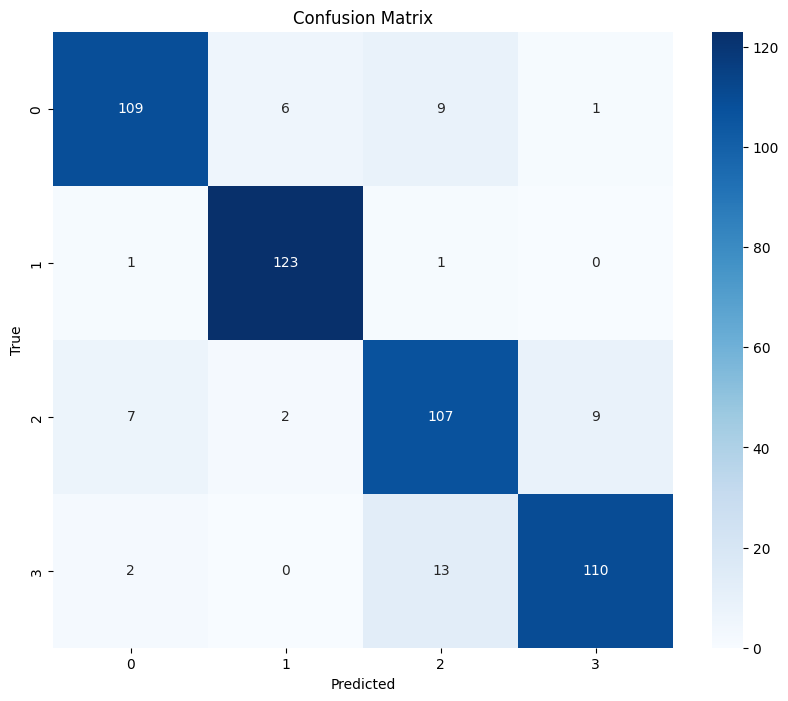

In [40]:
# Initialize the model
model = BERTClassifier(num_classes)
# Load the saved model
model.load_state_dict(torch.load('best_model.pth'))
# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Evaluate on test set
all_preds = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy and macro-F1 score
accuracy = accuracy_score(true_labels, all_preds)
macro_f1 = f1_score(true_labels, all_preds, average='macro')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Macro-F1 Score: {macro_f1:.4f}")

# Plot the confusion matrix
cm = confusion_matrix(true_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3'], yticklabels=['0', '1', '2', '3'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Store predictions in CSV
test_df['preds'] = all_preds
test_df.to_csv('bert_test.csv', index=False)

## Code to generate the output for any input enter by user (end to end classificaton)

In [39]:
# funtion to get the output for given model and text
# here device is the device used to trained the model we can switch as well.
def get_classification(sent_embedd,model=vanilla_rnn_model,device=device):
    model.eval()
    preds=None
    with torch.no_grad():
        # we have make it work in batche so we have unsqeeze to that it will of size [1,max_seq_length]
        # where max_seq_length means maximum allowed sequence
        input_ids, attention_mask= sent_embedd
        input_ids, attention_mask=input_ids.unsqueeze(0), attention_mask.unsqueeze(0)
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
    return preds
# Initialize the model
model = BERTClassifier(num_classes)
# Load the saved model
model.load_state_dict(torch.load('best_model.pth'))
# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# assume we have a text which is enter by user and want to know which 
# (World, Sports, Business, Sci/Tech).
class_labels=["World", "Sports", "Business", "Sci/Tech"]
data =input("Enter the data to find the class of (World, Sports, Business, Sci/Tech).\n")
# process the input text as same as the trainig is done or we can apply based on where data is comming from.
processed_text=preprocess_text(data)
# create embedding
# Initialize the BERT tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize and pad the sequences
max_length = 512

# Tokenize train sentences
encodings = tokenizer(processed_text, truncation=True, padding=True, max_length=max_length)
input_ids = torch.tensor(encodings['input_ids'])
attention_masks = torch.tensor(encodings['attention_mask'])
# encoding needed for the bert to classify the text
input_encoding=(input_ids,attention_masks)
# USING BERT Classifier
prediction_BERT=get_classification(input_encoding,model)
print("Classificaiton using BERT Classifier is: ",class_labels[prediction_BERT[0]])

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Enter the data to find the class of (World, Sports, Business, Sci/Tech).
 indias lowcost airline eyes business travel afp afp indias pioneer lowcost carrier air deccan plans raise million dollars private equity shedding percent stake also aims enter corporate business jet segment chairman said


Classificaiton using BERT Classifier is:  Business


## Other Varient of the RNN is Machine Translation
- Since the Machine Translation have one sequence in one language and other in other language problem both of them can be different length.
- Other Major Problem is How to train them.
- even after training how the generaiton of language will work
- Here in enoder and decoder every word goes to lstm because to resolve problems of vanishing gradient and to maintain the importance of previous words
- 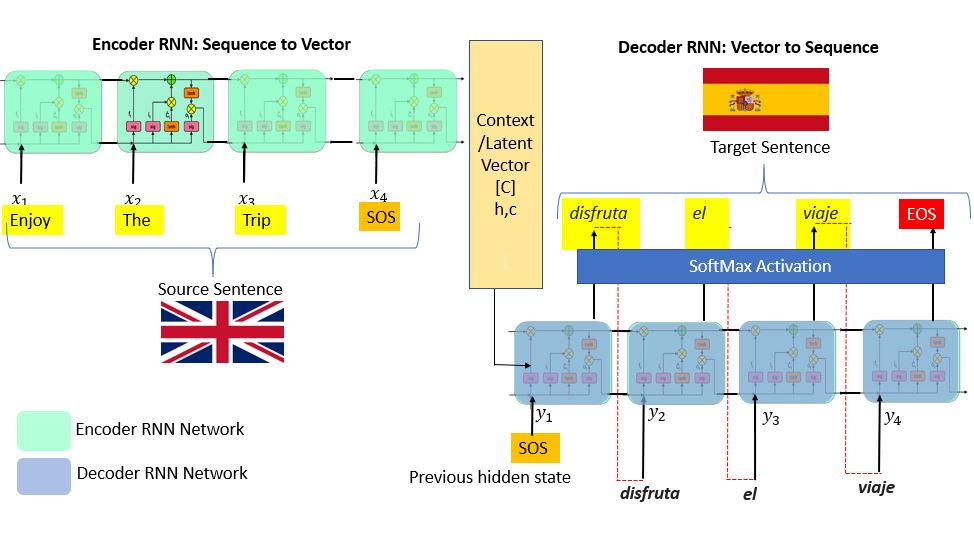

                - Encoder Decoder Arcitecture

In [2]:
# load the dataset
data_df= pd.read_csv('/kaggle/input/englishspanish-translation-dataset/data.csv')
# preprocess the text
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    # text = re.sub('<[^<]+?>', '', text)
    text = re.sub('\n', '', text)
    text = re.sub(r'[^\w]',' ',text)
    text = re.sub('\w*\d\w*', '', text)
    return text
data_df.english = data_df.english.map(clean_text)
data_df.spanish = data_df.spanish.map(clean_text)

In [3]:
# add start and end to every sentence
def add_start_end(text):
    text = f'<start> {text} <end>'
    return text
data_df.english = data_df.english.map(add_start_end)
data_df.spanish = data_df.spanish.map(add_start_end)

In [7]:
data_df.spanish[:3]

0      <start> ve  <end>
1    <start> vete  <end>
2    <start> vaya  <end>
Name: spanish, dtype: object

## Building Encoder-Decoder Architecture

In [41]:
import torch.nn as nn
def init_seq2seq(module):  #@save
    """Initialize weights for sequence-to-sequence learning."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)# one of technique for weight intialiser
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

class Seq2SeqEncoder(nn.Module):
    """Simple RNN encoder."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        # embeddding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # single sru layer
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)
    def forward(self, X):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))  # Transpose and convert to long
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state
def check_shape(tensor, expected_shape, name=""):
    """Simple function to check if a tensor has the expected shape."""
    if tensor.shape != expected_shape:
        print(f"Error: {name} shape mismatch. Expected: {expected_shape}, Actual: {tensor.shape}")
    else:
        print(f"{name} shape matches expectation: {tensor.shape}")
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)
#print(enc_outputs, enc_state)
class Seq2SeqDecoder(nn.Module):
    """The RNN decoder for sequence-to-sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)  # Output layer
        self.apply(init_seq2seq)  # Assuming init_seq2seq is defined elsewhere

    def init_state(self, enc_all_outputs):
        """
        Initializes the decoder state with the final output of the encoder.

        Args:
            enc_all_outputs: A tensor of shape (batch_size, num_steps_enc, num_hiddens)
              representing the outputs of all steps from the encoder.

        Returns:
            A list containing the final encoder output (for attention mechanisms)
            and a zero-initialized hidden state for the decoder RNN.
        """
        batch_size = enc_all_outputs.shape[0]  # Get batch size from encoder output
        return [enc_all_outputs[-1], torch.zeros(batch_size, self.rnn.hidden_size)]
    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int32))  # Transpose and convert to long
        # embs shape: (num_steps, batch_size, embed_size)

        enc_output, hidden_state = state  # Unpack the state

        # Concatenate context vector with embedded inputs at each step
        context = enc_output.unsqueeze(0).repeat(embs.shape[0], 1, 1)  # Broadcast context
        embs_and_context = torch.cat((embs, context), dim=2)  # Concatenate on feature dimension

        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs)  # Apply output layer
        outputs = outputs.swapaxes(0, 1)  # Swap axes for consistency

        return outputs, hidden_state  # Return outputs and new hidden state


In [42]:
class Seq2Seq(nn.Module):  # Inherit from nn.Module instead of d2l.EncoderDecoder
    """The RNN encoder-decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.tgt_pad = tgt_pad  # Target padding token
        self.lr = lr
        self.loss = nn.CrossEntropyLoss(reduction='mean', ignore_index=tgt_pad)  # Define loss function

    def forward(self, X, Y):
        """
        Performs a forward pass through the encoder-decoder model.

        Args:
            X: Input sequences (batch_size, num_steps_enc)
            Y: Target sequences (batch_size, num_steps_dec)

        Returns:
            Y_hat: Predicted target sequences (batch_size, num_steps_dec, vocab_size)
        """
        enc_outputs = self.encoder(X)  # Pass input through encoder
        state = self.decoder.init_state(enc_outputs)  # Initialize decoder state
        Y_hat, _ = self.decoder(Y[:-1], state)  # Decode target excluding last token
        return Y_hat
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    def loss(self, Y_hat, Y):
        l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
        mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
        return (l * mask).sum() / mask.sum()

## Attention Mechanisms and Transformers Arcitecture 
- At the present moment, the dominant models for nearly all natural language processing tasks are based on the Transformer architecture. Given any new task in natural language processing, the default first-pass approach is to grab a large Transformer-based pretrained model, (e.g., BERT (Devlin et al., 2018), ELECTRA (Clark et al., 2020), RoBERTa (Liu et al., 2019), or Longformer (Beltagy et al., 2020)) adapting the output layers as necessary, and fine-tuning the model on the available data for the downstream task. If you have been paying attention to the last few years of breathless news coverage centered on OpenAI’s large language models, then you have been tracking a conversation centered on the GPT-2 and GPT-3 Transformer-based models (Brown et al., 2020, Radford et al., 2019).
### Idea Behind the Attention mechanism
- The core idea behind the Transformer model is the attention mechanism, an innovation that was originally envisioned as an enhancement for encoder–decoder RNNs applied to sequence-to-sequence applications.
- As We know Previous Encoder-Decoder Model is the entire input was compressed by the encoder into a single fixed-length vector to be fed into the decoder (As Shown in the above Machine Translation problem). problem with this architecture is that whenever it decoding any output then it uses the compressed output produced by the encoder but some time an output only depend on only certain part of encoder.
- So Idea of Attention is that rather than compressing the input, it might be better for the decoder to revisit the input sequence at every step. Moreover, rather than always seeing the same representation of the input, one might imagine that the decoder should selectively focus on particular parts of the input sequence at particular decoding steps. shown in below image
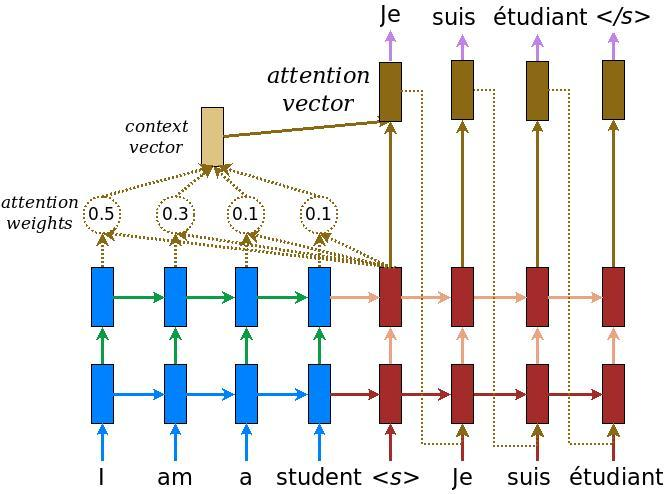

- The high-level idea is that the encoder could produce a representation of length equal to the original input sequence. Then, at decoding time, the decoder can (via some control mechanism) receive as input a context vector consisting of a weighted sum of the representations on the input at each time step. Intuitively, the weights determine the extent to which each step’s context “focuses” on each input token, and the key is to make this process for assigning the weights differentiable so that it can be learned along with all of the other neural network parameters.

####  Vaswani et al. (2017) proposed the Transformer architecture that show significant improvement over the above ways described
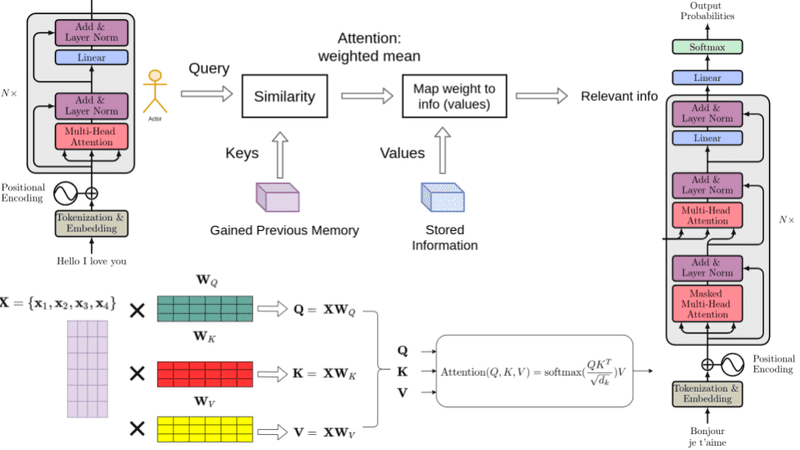